In [350]:
import numpy as np
from lattice_class import *
from hamiltonian_constructor_class import *
import scipy.linalg
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 150
plt.rcParams["savefig.dpi"] = 150

[140, 125, 110, 95]


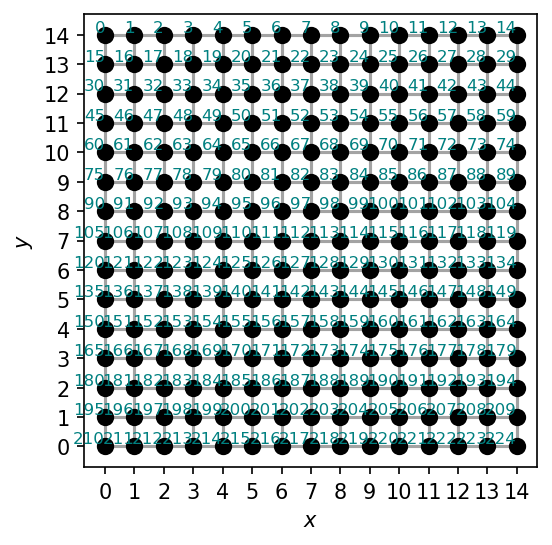

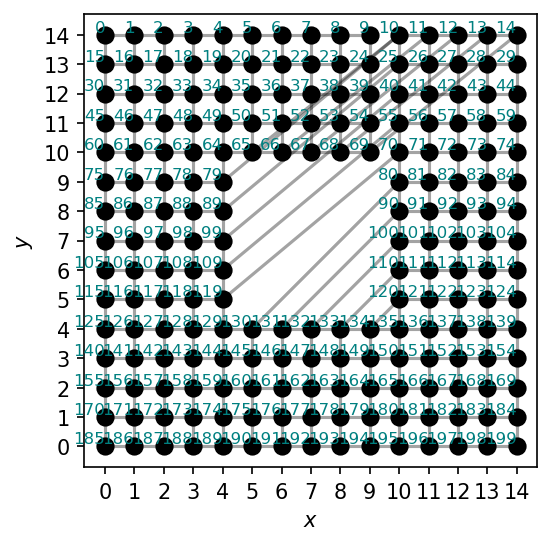

In [351]:
# Physical parameters
mu = 2.0
delta = complex(1.0, 0.0)
t = 1

N_hole = 5
N = 3 * N_hole
lattice = SquareLattice(N, BC="open")
middle_sites = [
    (N - N_hole) // 2 * N + (N - N_hole) // 2 + i * N + j
    for i in range(N_hole)
    for j in range(N_hole)
]

lattice.plot(True)
print([2 * N_hole * N + N_hole - (i + 1) * N for i in range(N_hole - 1)])

lattice.glue_bond(
    [2 * N_hole * N + N_hole + i for i in range(N_hole)],
    [N_hole * N + 2 * N_hole + i * N for i in range(N_hole)],
    (0, 2),
    codim=1,
)
lattice.glue_bond(
    [2 * N_hole * N + N_hole - 1 - (i + 1) * N for i in range(N_hole - 1)],
    [N_hole * N + 2 * N_hole - (i + 1) * N for i in range(N_hole - 1)],
    (1, 3),
    codim=1,
)
lattice.glue_bond([N_hole * N + N_hole - 1], [2 * N_hole], (1, 3), codim=1)
lattice.glue_bond([(N_hole - 1) * N + N_hole], [2 * N_hole], (2, 0), codim=1)
lattice.glue_bond(
    [(N_hole - 1) * N + N_hole + i + 1 for i in range(N_hole - 1)],
    [2 * N_hole + i + 1 for i in range(N_hole - 1)],
    (2, 0),
    codim=1,
)

lattice.remove_sites(middle_sites)
lattice.remove_bonds(
    [(2 * N_hole - 1 + i * N, 2 * N_hole + i * N) for i in range(N_hole)]
)

# lattice.move_sites([i*N +j for i in range(N//3) for j in range(2*N//3 + 1)], (0.0, +3.0))
# lattice.move_sites([7, 8, 9, 17, 18, 19, 27, 28, 29], (-3.0, -0.5))
# lattice.move_sites([34, 35, 36, 41, 42, 43], (-1.5, -0.25))

num_sites = lattice.get_num_sites()
lattice_sites = lattice.get_sites()

lattice.plot(True)

# Phase parameters
n = -1
hop_phase_triangle = np.exp(n * np.pi * 1j / 2)
hop_phase_pentagon = hop_phase_triangle.conjugate()
flagged_bonds_triangle = [
    (
        N_hole * N + N_hole + 2 * N_hole * i,
        N_hole * N + N_hole * (2 * N_hole) + N_hole + i,
    )
    for i in range(N_hole)
]
flagged_bonds_pentagon = []

In [352]:
# print(lattice.get_local_bond_index(14, 153))

flagged_bonds_triangle =  [(80, 130), (90, 131), (100, 132), (110, 133), (120, 134)]
hop_phase_triangle =  (6.123233995736766e-17-1j)
hop_phase_pentagon =  (6.123233995736766e-17+1j)
[398 399 400 401]
Lowest found energy:  0.005506339713291737
Index of lowest absolute energy:  399


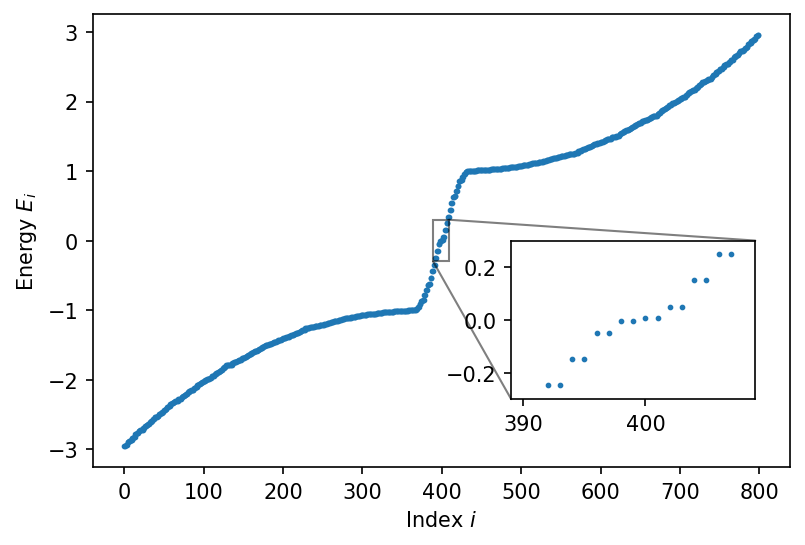

[-0.00550634 -0.00550634  0.00550634  0.00550634]


In [353]:
print("flagged_bonds_triangle = ", flagged_bonds_triangle)

Ham_constructor = HamiltonianConstructor(mu, t, t, delta)
H_direct_lattice = Ham_constructor.construct_direct_lattice_hamiltonian(lattice)
block_indices = Ham_constructor.get_block_indices(lattice.get_num_sites())


print("hop_phase_triangle = ", hop_phase_triangle)
print("hop_phase_pentagon = ", hop_phase_pentagon)
for flagged_bond in flagged_bonds_triangle:
    Ham_constructor.add_phase(
        H_direct_lattice, flagged_bond, hop_phase_triangle, num_sites
    )

for flagged_bond in flagged_bonds_pentagon:
    Ham_constructor.add_phase(
        H_direct_lattice, flagged_bond, hop_phase_pentagon, num_sites
    )

energies, states = scipy.linalg.eigh(H_direct_lattice)

tol = 0.01
low_energy_indices = np.argwhere(np.abs(energies) < tol)[:, 0]
print(low_energy_indices)

print("Lowest found energy: ", np.min(np.abs(energies)))
gs_idx = np.argmin(np.abs(energies))
print("Index of lowest absolute energy: ", gs_idx)

# Energy scatter plot with zoom window
fig, ax = plt.subplots()
plt.xlabel(r"Index $i$")
plt.ylabel(r"Energy $E_{i}$")
ax.scatter(range(len(energies)), energies, s=3)
axins = ax.inset_axes([0.6, 0.15, 0.35, 0.35])
axins.scatter(range(len(energies)), energies, s=3, zorder=-100)
x1, x2, y1, y2 = gs_idx - 10, gs_idx + 10, -0.3, 0.3
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
ax.indicate_inset_zoom(axins, edgecolor="black")
plt.savefig(f"./plots/discl_dipole_spectrum_n_{n}.svg")
plt.show()

print(energies[gs_idx - 1 : gs_idx + 3])

idx = 399 with energy -0.005506339713291737


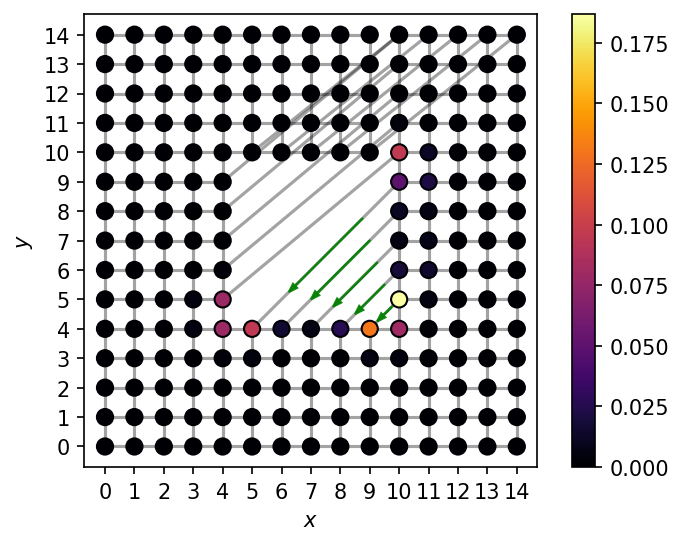

In [354]:
for gs_idx in range(gs_idx, gs_idx + 1):
    print(f"idx = {gs_idx} with energy {energies[gs_idx]}")
    gs_wave_function = states[:, gs_idx]
    gs_probabilities_nambu = np.square(np.abs(gs_wave_function))
    gs_probabilities = np.zeros(shape=(num_sites, 1))

    for site_idx in range(num_sites):
        gs_probabilities[site_idx] = np.sum(
            gs_probabilities_nambu[block_indices[site_idx]]
        )

    x_values = [k[0] for k in lattice_sites]
    y_values = [k[1] for k in lattice_sites]

    color_map = plt.get_cmap("inferno")
    sc = lattice.plot(
        False,
        c=(gs_probabilities),
        flagged_bonds=flagged_bonds_triangle,
        cmap=color_map,
    )
    plt.colorbar(sc)
    plt.savefig(f"./plots/discl_dipole_prob_distr_n_{n}.svg")
    plt.show()

[2.06665955e-08]


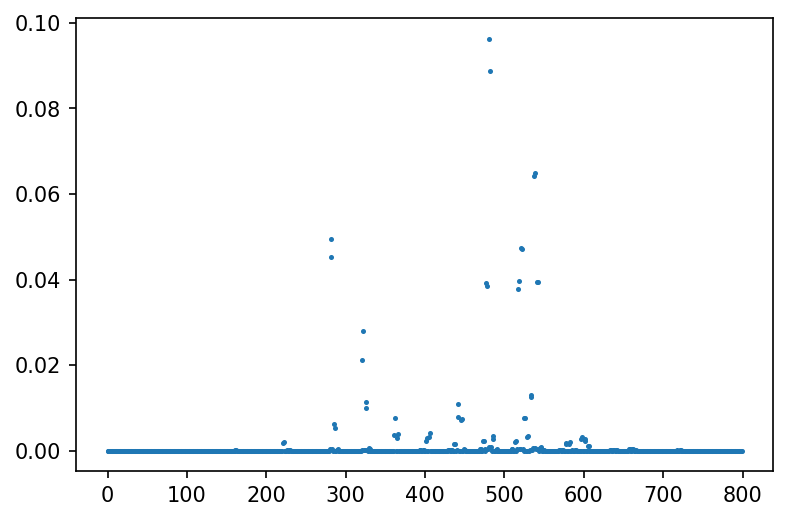

In [355]:
plt.scatter(range(len(gs_probabilities_nambu)), gs_probabilities_nambu, s=2)
print(gs_probabilities[18])

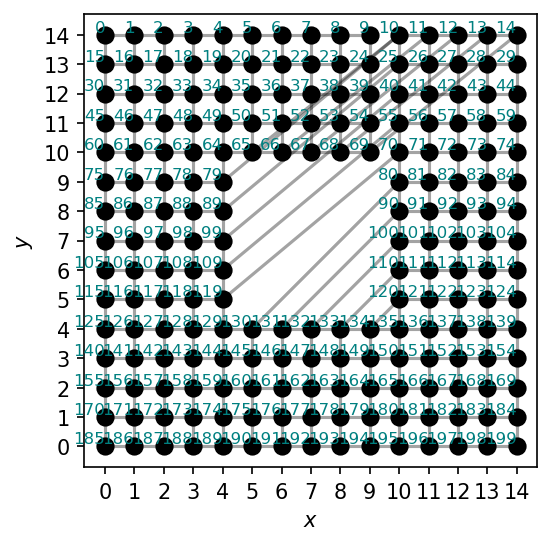

In [356]:
lattice.plot(True)

[80, 130, 135, 10, 81, 131, 136, 11, 82, 132, 137, 12, 83, 133, 138, 13, 84, 134, 139, 14, 90, 145, 150, 25, 91, 146, 151, 26, 92, 147, 152, 27, 93, 148, 153, 28, 94, 149, 154, 29, 100, 160, 165, 40, 101, 161, 166, 41, 102, 162, 167, 42, 103, 163, 168, 43, 104, 164, 169, 44, 110, 175, 180, 55, 111, 176, 181, 56, 112, 177, 182, 57, 113, 178, 183, 58, 114, 179, 184, 59, 120, 190, 195, 70, 121, 191, 196, 71, 122, 192, 197, 72, 123, 193, 198, 73, 124, 194, 199, 74]


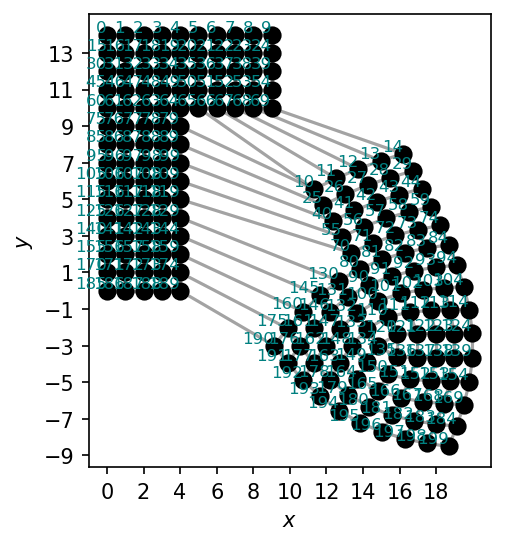

In [357]:
triangle_sites = []
for i in range(N_hole):
    for j in range(N_hole):
        triangle_sites.append(N_hole * N + N_hole + i * 2 * N_hole + j)
        triangle_sites.append(N_hole * N + N_hole * 2 * N_hole + N_hole + i * N + j)
        triangle_sites.append(N_hole * N + N_hole * 2 * N_hole + 2 * N_hole + i * N + j)
        triangle_sites.append(2 * N_hole + i * N + j)
        # triangle_sites.append(N_hole * N + N_hole * 2 * N_hole + i * N + j)

# triangle_sites = [i for i in range(lattice.get_num_sites())]
print(triangle_sites)


def transform_triangle(pos, defect_pos, angle_sign=1):
    pos = np.array([pos[0], pos[1]])
    defect_pos = np.array([defect_pos[0], defect_pos[1]])
    pos_shift = pos - defect_pos
    x, y = -pos_shift
    r = scipy.linalg.norm(pos_shift)
    angle = np.arctan2(-y, x)
    if angle < 0.0:
        angle = angle_sign * 2 * np.pi + angle
    angle = angle * 4 / 3
    angle += -np.pi / 3
    return (
        r * np.array([-np.cos(angle), np.sin(angle)])
        + defect_pos
        + np.array([6.0, -7.5])
    )


for itr in triangle_sites:
    lattice.move_site(
        itr, transform_triangle(lattice._sites[itr], (9.5, 4.5), angle_sign=1)
    )
    # lattice.move_site(itr, (lattice_sites[itr][0], -lattice_sites[itr][1]))

# sc = lattice.plot(
#     False, flagged_bonds=flagged_bonds_vortex, c=(gs_probabilities), cmap=color_map
# )
# plt.colorbar(sc)

lattice.plot(True)

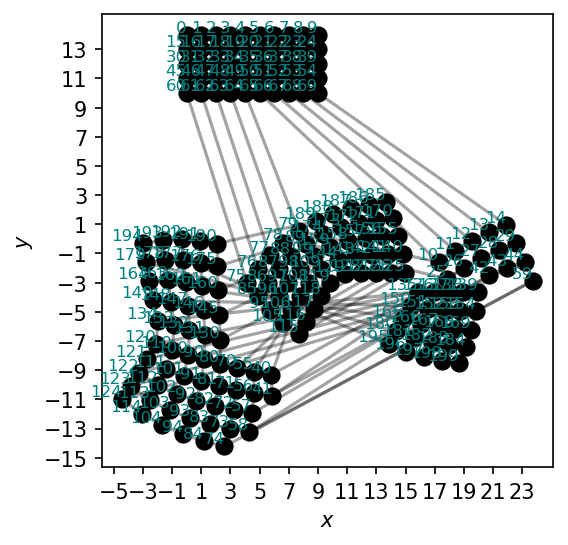

In [358]:
def transform_pentagon(pos, defect_pos, angle_sign=1):
    pos = np.array([pos[0], pos[1]])
    defect_pos = np.array([defect_pos[0], defect_pos[1]])
    pos_shift = pos - defect_pos
    x, y = pos_shift
    r = scipy.linalg.norm(pos_shift)
    angle = np.arctan2(y, x)
    if angle < 0.0:
        angle = angle_sign * 2 * np.pi + angle
    angle = angle * 4 / 3
    return r * np.array([np.cos(angle), np.sin(angle)]) + defect_pos


pentagon_sites = [i for i in range(lattice.get_num_sites())]
for triangle_site in [i * N + j for i in range(N_hole) for j in range(2 * N_hole)]:
    pentagon_sites.remove(triangle_site)

for site in [
    N_hole * N + N_hole * 2 * N_hole + 2 * N_hole + i * N + j
    for i in range(N_hole)
    for j in range(N_hole)
]:
    pentagon_sites.remove(site)

for itr in pentagon_sites:
    lattice.move_site(
        itr, transform_triangle(lattice._sites[itr], (4.5, 4.5), angle_sign=-1)
    )

lattice.plot(True)